# User Pairing Model


In [1]:
import pickle
import random
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

# === Config ===
USER_MATRIX_PATH = "/content/drive/MyDrive/datasets/user_matrix.pkl"
USER_TO_IDX_PATH = "/content/drive/MyDrive/datasets/user_to_idx.pkl"
SELECTED_USERS_PATH = "/content/drive/MyDrive/datasets/userplaylist_labeled_slices_fixed_downscaled/selected_user_ids.pkl"
OWNED_PLAYLISTS_PATH = "/content/drive/MyDrive/datasets/playlist_ownership/user_owned_playlists.pkl"
OUTPUT_PATH = "/content/drive/MyDrive/datasets/main_datasets/user_pairing_model/user_neighbors_downscaled.pkl"

TOP_K = 100
MIN_PL = 20
MAX_PL = 100
SEED = 42
random.seed(SEED)

# === Load all data ===
print("Loading sparse matrix and mappings...")
with open(USER_MATRIX_PATH, "rb") as f:
    user_matrix: csr_matrix = pickle.load(f)

with open(USER_TO_IDX_PATH, "rb") as f:
    user_to_idx = pickle.load(f)

with open(SELECTED_USERS_PATH, "rb") as f:
    selected_user_ids = pickle.load(f)

with open(OWNED_PLAYLISTS_PATH, "rb") as f:
    user_owned_playlists = pickle.load(f)

# === Prepare index mappings
idx_to_user = {v: k for k, v in user_to_idx.items()}
selected_idx = sorted([idx for uid, idx in user_to_idx.items() if idx in selected_user_ids])
sub_matrix = user_matrix[selected_idx]

print(f"✅ Using {len(selected_idx)} users for sub-matrix: shape = {sub_matrix.shape}")

# === Fit KNN model
print("Fitting sparse KNN model...")
knn = NearestNeighbors(n_neighbors=TOP_K + 1, algorithm="brute", metric="cosine", n_jobs=-1)
knn.fit(sub_matrix)

# === Neighbor selection
user_neighbors = {}
for i, user_row in enumerate(tqdm(sub_matrix, desc="Matching neighbors")):
    user_idx = selected_idx[i]
    distances, indices = knn.kneighbors(user_row, n_neighbors=TOP_K + 1)
    neighbor_indices = [selected_idx[nbr] for nbr in indices.flatten() if selected_idx[nbr] != user_idx]

    random.shuffle(neighbor_indices)  # Shuffle to avoid positional bias! Important issue that was fixed haha

    total_playlists = set()
    selected_neighbors = []

    for nbr_id in neighbor_indices:
        pl = user_owned_playlists.get(nbr_id, set())
        total_playlists.update(pl)
        selected_neighbors.append(nbr_id)
        if len(total_playlists) >= MIN_PL:
            if len(total_playlists) >= MAX_PL:
                break

    user_neighbors[user_idx] = selected_neighbors

# === Save results
with open(OUTPUT_PATH, "wb") as f:
    pickle.dump(user_neighbors, f)

print(f"✅ Saved {len(user_neighbors)} users with neighbors → {OUTPUT_PATH}")


Loading sparse matrix and mappings...
✅ Using 101713 users for sub-matrix: shape = (101713, 2397197)
Fitting sparse KNN model...


Matching neighbors: 101713it [2:09:25, 13.10it/s]


✅ Saved 101713 users with neighbors → /content/drive/MyDrive/datasets/main_datasets/user_pairing_model/user_neighbors_downscaled.pkl


## Explore KNN results!

✅ Loaded 101,713 users with neighbor lists.

📊 Neighbor Count Statistics:
 - Users analyzed       : 101,713
 - Min neighbors        : 1
 - Max neighbors        : 100
 - Mean neighbors       : 53.28
 - Median neighbors     : 47.0
 - 25th percentile      : 26.0
 - 75th percentile      : 84.0
 - 99th percentile      : 100.0


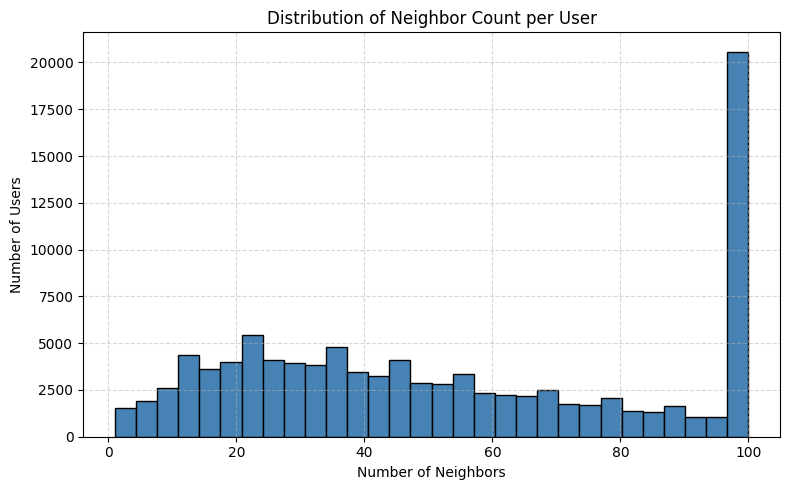


🔍 Sampling 5 users and showing their neighbors:

User 839918 has 100 neighbors → [217378, 311466, 344749, 96235, 259392, 47184, 212822, 441718, 432007, 721673, 723145, 547631, 542523, 841074, 32589, 721793, 1017428, 666201, 392528, 216409, 905127, 955490, 374635, 40848, 110887, 999911, 100612, 423158, 26155, 335158, 776561, 673220, 559456, 275626, 410811, 239733, 612447, 487096, 661824, 807296, 582273, 913242, 112904, 495827, 934439, 92154, 460814, 471463, 457859, 61271, 816101, 193017, 219519, 190092, 577912, 925809, 900215, 593920, 364357, 508700, 255937, 45361, 486620, 269367, 635270, 896412, 863140, 935726, 63674, 324802, 512972, 981195, 606004, 493655, 953937, 952624, 700783, 257056, 540487, 953588, 546329, 91137, 290208, 943492, 760265, 821710, 289558, 258332, 557138, 335118, 459659, 143177, 863631, 591470, 380020, 895311, 835349, 998010, 586774, 242284]

User 146314 has 12 neighbors → [738413, 611960, 301064, 259166, 48204, 11099, 577882, 240745, 860639, 310396, 941483, 998258]

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random

# === Config ===
NEIGHBOR_FILE = "/content/drive/MyDrive/datasets/main_datasets/user_pairing_model/user_neighbors_downscaled.pkl"
SAMPLE_USERS = 5
SEED = 42
random.seed(SEED)

# === Load Data ===
with open(NEIGHBOR_FILE, "rb") as f:
    user_neighbors = pickle.load(f)

print(f"✅ Loaded {len(user_neighbors):,} users with neighbor lists.")

# === Compute Stats ===
neighbor_counts = [len(v) for v in user_neighbors.values()]

print("\n📊 Neighbor Count Statistics:")
print(f" - Users analyzed       : {len(neighbor_counts):,}")
print(f" - Min neighbors        : {min(neighbor_counts)}")
print(f" - Max neighbors        : {max(neighbor_counts)}")
print(f" - Mean neighbors       : {np.mean(neighbor_counts):.2f}")
print(f" - Median neighbors     : {np.median(neighbor_counts)}")
print(f" - 25th percentile      : {np.percentile(neighbor_counts, 25)}")
print(f" - 75th percentile      : {np.percentile(neighbor_counts, 75)}")
print(f" - 99th percentile      : {np.percentile(neighbor_counts, 99)}")

# === Plot Histogram ===
plt.figure(figsize=(8, 5))
plt.hist(neighbor_counts, bins=30, color="steelblue", edgecolor="black")
plt.title("Distribution of Neighbor Count per User")
plt.xlabel("Number of Neighbors")
plt.ylabel("Number of Users")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# === Sample Users for Manual Check ===
print(f"\n🔍 Sampling {SAMPLE_USERS} users and showing their neighbors:")
sample_keys = random.sample(list(user_neighbors.keys()), SAMPLE_USERS)
for uid in sample_keys:
    print(f"\nUser {uid} has {len(user_neighbors[uid])} neighbors → {user_neighbors[uid]}")import pickle



In [6]:
import pickle
import random

# === Config ===
NEIGHBOR_FILE = "/content/drive/MyDrive/datasets/main_datasets/user_pairing_model/user_neighbors_downscaled.pkl"
OWNED_PLAYLISTS_FILE = "/content/drive/MyDrive/datasets/playlist_ownership/user_owned_playlists.pkl"
NUM_USERS_TO_SAMPLE = 5

# === Load Files ===
with open(NEIGHBOR_FILE, "rb") as f:
    user_neighbors = pickle.load(f)

with open(OWNED_PLAYLISTS_FILE, "rb") as f:
    user_owned_playlists = pickle.load(f)

# === Sample and Analyze ===
print(f"Sampling {NUM_USERS_TO_SAMPLE} users and checking playlist access:")
sample_users = random.sample(list(user_neighbors.keys()), NUM_USERS_TO_SAMPLE)

for uid in sample_users:
    neighbors = user_neighbors[uid]
    all_playlists = set()

    for nbr in neighbors:
        all_playlists.update(user_owned_playlists.get(nbr, set()))

    print(f"\nUser {uid}:")
    print(f" - Paired with {len(neighbors)} users")
    print(f" - Has access to {len(all_playlists)} unique playlists from neighbors")


🎯 Sampling 5 users and checking playlist access:

User 321678:
 - Paired with 60 users
 - Has access to 104 unique playlists from neighbors

User 293189:
 - Paired with 22 users
 - Has access to 110 unique playlists from neighbors

User 183403:
 - Paired with 55 users
 - Has access to 115 unique playlists from neighbors

User 967145:
 - Paired with 20 users
 - Has access to 104 unique playlists from neighbors

User 134666:
 - Paired with 97 users
 - Has access to 100 unique playlists from neighbors



📊 User Popularity (Times a User Was Paired as Neighbor):
 - Users selected as neighbor: 101,509
 - Min times selected        : 1
 - Max times selected        : 2979
 - Mean                      : 53.39
 - Median                    : 29.0
 - 90th percentile           : 107.0
 - 99th percentile           : 433.0


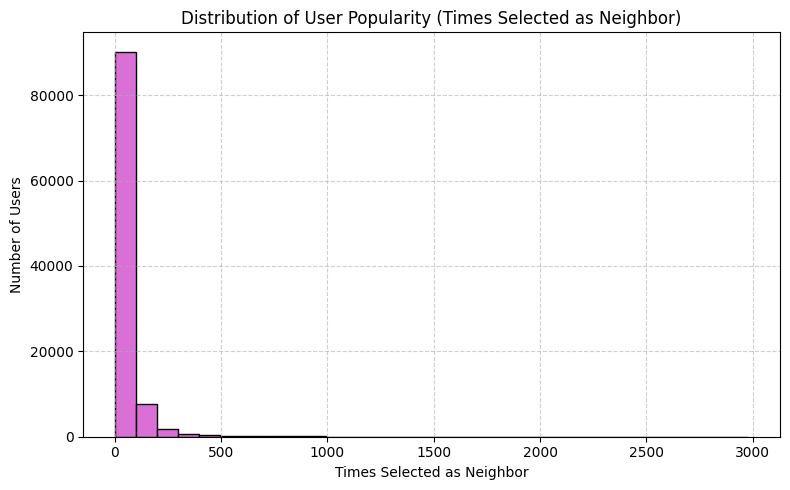

In [8]:
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# === Config ===
NEIGHBOR_FILE = "/content/drive/MyDrive/datasets/main_datasets/user_pairing_model/user_neighbors_downscaled.pkl"

# === Load Neighbors ===
with open(NEIGHBOR_FILE, "rb") as f:
    user_neighbors = pickle.load(f)

# === Invert Mapping to Count Popularity ===
neighbor_flat_list = [nbr for neighbors in user_neighbors.values() for nbr in neighbors]
popularity_counter = Counter(neighbor_flat_list)

popularity_counts = list(popularity_counter.values())

# === Stats ===
print("\n📊 User Popularity (Times a User Was Paired as Neighbor):")
print(f" - Users selected as neighbor: {len(popularity_counts):,}")
print(f" - Min times selected        : {min(popularity_counts)}")
print(f" - Max times selected        : {max(popularity_counts)}")
print(f" - Mean                      : {np.mean(popularity_counts):.2f}")
print(f" - Median                    : {np.median(popularity_counts)}")
print(f" - 90th percentile           : {np.percentile(popularity_counts, 90)}")
print(f" - 99th percentile           : {np.percentile(popularity_counts, 99)}")

# === Histogram ===
plt.figure(figsize=(8, 5))
plt.hist(popularity_counts, bins=30, color="orchid", edgecolor="black")
plt.title("Distribution of User Popularity (Times Selected as Neighbor)")
plt.xlabel("Times Selected as Neighbor")
plt.ylabel("Number of Users")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


Computing playlist coverage: 100%|██████████| 101713/101713 [00:02<00:00, 48662.91it/s]



📊 Playlists Accessible via Neighbors:
 - Users analyzed         : 101,713
 - Min playlists          : 0
 - Max playlists          : 199
 - Mean playlists         : 103.33
 - Median playlists       : 103.0
 - 25th percentile        : 100.0
 - 75th percentile        : 115.0
 - 99th percentile        : 186.0


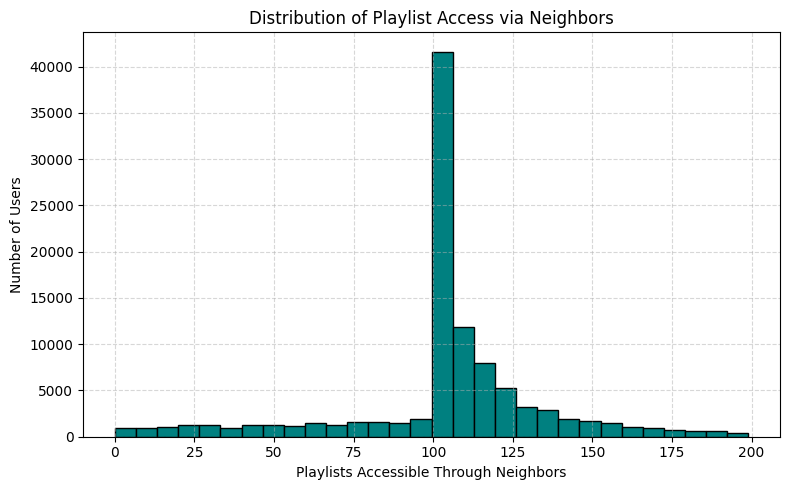

In [10]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# === Config ===
NEIGHBOR_FILE = "/content/drive/MyDrive/datasets/main_datasets/user_pairing_model/user_neighbors_downscaled.pkl"
OWNED_PLAYLISTS_FILE = "/content/drive/MyDrive/datasets/playlist_ownership/user_owned_playlists.pkl"

# === Load Data ===
with open(NEIGHBOR_FILE, "rb") as f:
    user_neighbors = pickle.load(f)

with open(OWNED_PLAYLISTS_FILE, "rb") as f:
    user_owned_playlists = pickle.load(f)

# === Compute playlists accessible via neighbors ===
playlist_counts = []

for uid, neighbors in tqdm(user_neighbors.items(), desc="Computing playlist coverage"):
    playlists = set()
    for nbr in neighbors:
        playlists.update(user_owned_playlists.get(nbr, set()))
    playlist_counts.append(len(playlists))

# === Stats ===
print("\n📊 Playlists Accessible via Neighbors:")
print(f" - Users analyzed         : {len(playlist_counts):,}")
print(f" - Min playlists          : {min(playlist_counts)}")
print(f" - Max playlists          : {max(playlist_counts)}")
print(f" - Mean playlists         : {np.mean(playlist_counts):.2f}")
print(f" - Median playlists       : {np.median(playlist_counts)}")
print(f" - 25th percentile        : {np.percentile(playlist_counts, 25)}")
print(f" - 75th percentile        : {np.percentile(playlist_counts, 75)}")
print(f" - 99th percentile        : {np.percentile(playlist_counts, 99)}")

# === Plot histogram ===
plt.figure(figsize=(8, 5))
plt.hist(playlist_counts, bins=30, color="teal", edgecolor="black")
plt.title("Distribution of Playlist Access via Neighbors")
plt.xlabel("Playlists Accessible Through Neighbors")
plt.ylabel("Number of Users")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


## Second run with some fixes to allow all users to get a neighbour, and also control the surge at 100 playlists.

In [14]:
import os
import pickle
import random
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

# === CONFIGURATION ===
USER_MATRIX_PATH = "/content/drive/MyDrive/datasets/user_matrix.pkl"
USER_TO_IDX_PATH = "/content/drive/MyDrive/datasets/user_to_idx.pkl"
SELECTED_USERS_PATH = "/content/drive/MyDrive/datasets/userplaylist_labeled_slices_fixed_downscaled/selected_user_ids.pkl"
OWNED_PLAYLISTS_PATH = "/content/drive/MyDrive/datasets/playlist_ownership/user_owned_playlists.pkl"
OUTPUT_PATH = "/content/drive/MyDrive/datasets/main_datasets/user_pairing_model/user_neighbors_downscaled_v2.pkl"


TEST_ON_1PERCENT_USERS = True

# PARAMETERS
TOP_K = 100           # Number of candidates retrieved from KNN
MAX_NEIGHBORS = 50    # Soft cap on neighbor count
MIN_PL = 20           # Hard minimum on total playlists gathered from neighbors
SEED = 42
random.seed(SEED)

# === Load Data ===
print("Loading required files...")
with open(USER_MATRIX_PATH, "rb") as f:
    user_matrix: csr_matrix = pickle.load(f)

with open(USER_TO_IDX_PATH, "rb") as f:
    user_to_idx = pickle.load(f)

with open(SELECTED_USERS_PATH, "rb") as f:
    selected_user_ids = pickle.load(f)

with open(OWNED_PLAYLISTS_PATH, "rb") as f:
    user_owned_playlists = pickle.load(f)

# === Prepare index mappings and submatrix
idx_to_user = {v: k for k, v in user_to_idx.items()}
selected_idx = sorted([idx for uid, idx in user_to_idx.items() if idx in selected_user_ids])
sub_matrix = user_matrix[selected_idx]

print(f"✅ Sub-matrix created → shape = {sub_matrix.shape}")

# === Fit KNN model (cosine distance)
print("Fitting NearestNeighbors model (cosine distance)...")
knn = NearestNeighbors(n_neighbors=TOP_K + 1, algorithm="brute", metric="cosine", n_jobs=-1)
knn.fit(sub_matrix)

# === Find neighbors
print("Matching users to neighbors...")
user_neighbors = {}
for i, user_row in enumerate(tqdm(sub_matrix, desc="Pairing users")):
    user_idx = selected_idx[i]
    distances, indices = knn.kneighbors(user_row, n_neighbors=TOP_K + 1)
    neighbor_indices = [selected_idx[nbr] for nbr in indices.flatten() if selected_idx[nbr] != user_idx]
    random.shuffle(neighbor_indices)  # Remove ordering bias, vry important

    total_playlists = set()
    selected_neighbors = []

    for nbr_id in neighbor_indices:
        pl = user_owned_playlists.get(nbr_id, set())
        if not pl:
            continue
        total_playlists.update(pl)
        selected_neighbors.append(nbr_id)

        if len(selected_neighbors) >= MAX_NEIGHBORS and len(total_playlists) >= MIN_PL:
            break

    user_neighbors[user_idx] = selected_neighbors

# === Save results
os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)
with open(OUTPUT_PATH, "wb") as f:
    pickle.dump(user_neighbors, f)

print(f"✅ Saved neighbor pairs for {len(user_neighbors)} users → {OUTPUT_PATH}")

Loading required files...
✅ Sub-matrix created → shape = (101713, 2397197)
Fitting NearestNeighbors model (cosine distance)...
Matching users to neighbors...


Pairing users: 101713it [2:25:17, 11.67it/s]


✅ Saved neighbor pairs for 101713 users → /content/drive/MyDrive/datasets/main_datasets/user_pairing_model/user_neighbors_downscaled_v2.pkl


✅ Loaded 101,713 users with neighbor lists.

📊 Neighbor Count Statistics:
 - Users analyzed       : 101,713
 - Min neighbors        : 0
 - Max neighbors        : 50
 - Mean neighbors       : 36.79
 - Median neighbors     : 39.0
 - 25th percentile      : 30.0
 - 75th percentile      : 48.0
 - 99th percentile      : 50.0


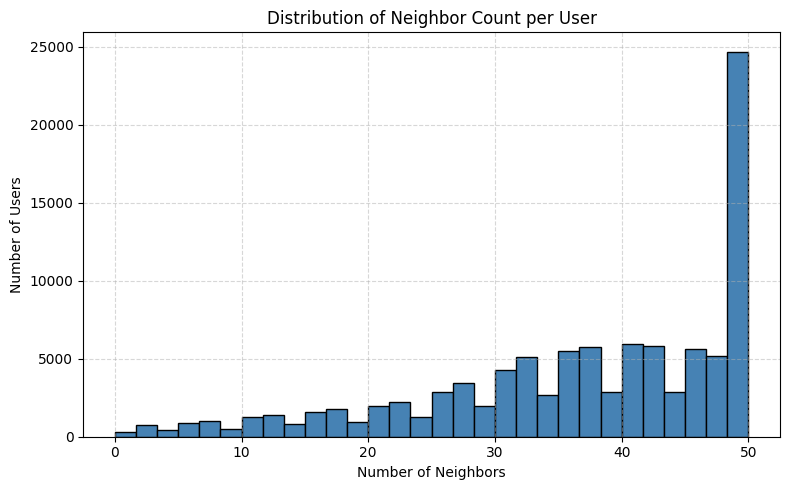


🔍 Sampling 5 users and showing their neighbors:

User 839918 has 18 neighbors → [259392, 721793, 666201, 216409, 905127, 335158, 410811, 239733, 112904, 495827, 934439, 816101, 508700, 269367, 289558, 459659, 143177, 998010]

User 146314 has 47 neighbors → [259166, 48204, 577882, 310396, 941483, 998258, 748839, 377078, 996253, 835390, 300526, 627980, 678783, 928015, 933486, 753675, 830345, 933427, 440952, 158768, 392110, 168918, 374179, 285948, 854860, 234822, 750985, 846302, 671641, 703013, 317125, 737975, 23559, 16922, 644359, 801537, 779064, 206563, 53042, 187667, 962544, 863393, 249686, 353787, 692887, 671318, 792109]

User 32785 has 34 neighbors → [285278, 501757, 638551, 431764, 536989, 192588, 637385, 438507, 970184, 955195, 246192, 779626, 338269, 322865, 970740, 910921, 240017, 275771, 610706, 772376, 746160, 43863, 17146, 654043, 922859, 520617, 301128, 361050, 526749, 377520, 572841, 864326, 842920, 991286]

User 974206 has 49 neighbors → [47084, 962627, 624669, 561536, 438

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random

# === Config ===
NEIGHBOR_FILE = "/content/drive/MyDrive/datasets/main_datasets/user_pairing_model/user_neighbors_downscaled_v2.pkl"
SAMPLE_USERS = 5
SEED = 42
random.seed(SEED)

# === Load Data ===
with open(NEIGHBOR_FILE, "rb") as f:
    user_neighbors = pickle.load(f)

print(f"✅ Loaded {len(user_neighbors):,} users with neighbor lists.")

# === Compute Stats ===
neighbor_counts = [len(v) for v in user_neighbors.values()]

print("\n📊 Neighbor Count Statistics:")
print(f" - Users analyzed       : {len(neighbor_counts):,}")
print(f" - Min neighbors        : {min(neighbor_counts)}")
print(f" - Max neighbors        : {max(neighbor_counts)}")
print(f" - Mean neighbors       : {np.mean(neighbor_counts):.2f}")
print(f" - Median neighbors     : {np.median(neighbor_counts)}")
print(f" - 25th percentile      : {np.percentile(neighbor_counts, 25)}")
print(f" - 75th percentile      : {np.percentile(neighbor_counts, 75)}")
print(f" - 99th percentile      : {np.percentile(neighbor_counts, 99)}")

# === Plot Histogram ===
plt.figure(figsize=(8, 5))
plt.hist(neighbor_counts, bins=30, color="steelblue", edgecolor="black")
plt.title("Distribution of Neighbor Count per User")
plt.xlabel("Number of Neighbors")
plt.ylabel("Number of Users")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# === Sample Users for Manual Check ===
print(f"\n🔍 Sampling {SAMPLE_USERS} users and showing their neighbors:")
sample_keys = random.sample(list(user_neighbors.keys()), SAMPLE_USERS)
for uid in sample_keys:
    print(f"\nUser {uid} has {len(user_neighbors[uid])} neighbors → {user_neighbors[uid]}")

In [16]:
import pickle
import random

# === Config ===
NEIGHBOR_FILE = "/content/drive/MyDrive/datasets/main_datasets/user_pairing_model/user_neighbors_downscaled_v2.pkl"
OWNED_PLAYLISTS_FILE = "/content/drive/MyDrive/datasets/playlist_ownership/user_owned_playlists.pkl"
NUM_USERS_TO_SAMPLE = 5

# === Load Files ===
with open(NEIGHBOR_FILE, "rb") as f:
    user_neighbors = pickle.load(f)

with open(OWNED_PLAYLISTS_FILE, "rb") as f:
    user_owned_playlists = pickle.load(f)

# === Sample and Analyze ===
print(f"Sampling {NUM_USERS_TO_SAMPLE} users and checking playlist access:")
sample_users = random.sample(list(user_neighbors.keys()), NUM_USERS_TO_SAMPLE)

for uid in sample_users:
    neighbors = user_neighbors[uid]
    all_playlists = set()

    for nbr in neighbors:
        all_playlists.update(user_owned_playlists.get(nbr, set()))

    print(f"\nUser {uid}:")
    print(f" - Paired with {len(neighbors)} users")
    print(f" - Has access to {len(all_playlists)} unique playlists from neighbors")


Sampling 5 users and checking playlist access:

User 321678:
 - Paired with 36 users
 - Has access to 156 unique playlists from neighbors

User 293189:
 - Paired with 46 users
 - Has access to 618 unique playlists from neighbors

User 183403:
 - Paired with 42 users
 - Has access to 205 unique playlists from neighbors

User 967145:
 - Paired with 39 users
 - Has access to 343 unique playlists from neighbors

User 134666:
 - Paired with 21 users
 - Has access to 102 unique playlists from neighbors



📊 User Popularity (Times a User Was Paired as Neighbor):
 - Users selected as neighbor: 39,634
 - Min times selected        : 1
 - Max times selected        : 2348
 - Mean                      : 94.41
 - Median                    : 57.0
 - 90th percentile           : 207.0
 - 99th percentile           : 609.0


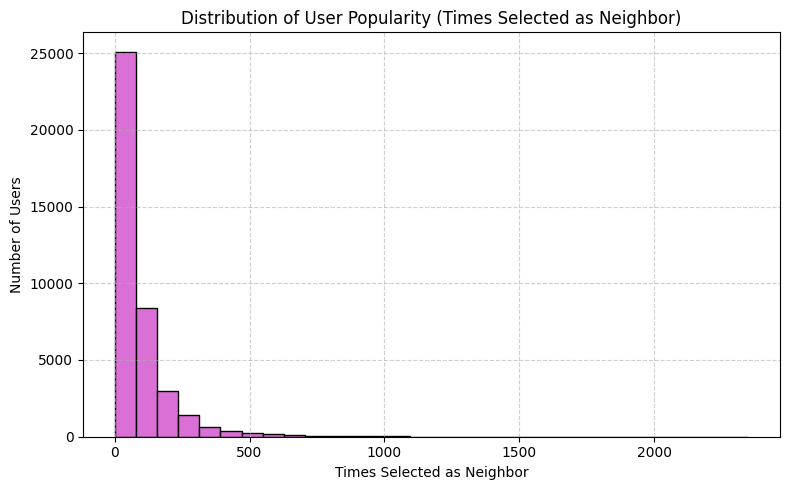

In [17]:
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# === Config ===
NEIGHBOR_FILE = "/content/drive/MyDrive/datasets/main_datasets/user_pairing_model/user_neighbors_downscaled_v2.pkl"

# === Load Neighbors ===
with open(NEIGHBOR_FILE, "rb") as f:
    user_neighbors = pickle.load(f)

# === Invert Mapping to Count Popularity ===
neighbor_flat_list = [nbr for neighbors in user_neighbors.values() for nbr in neighbors]
popularity_counter = Counter(neighbor_flat_list)

popularity_counts = list(popularity_counter.values())

# === Stats ===
print("\n📊 User Popularity (Times a User Was Paired as Neighbor):")
print(f" - Users selected as neighbor: {len(popularity_counts):,}")
print(f" - Min times selected        : {min(popularity_counts)}")
print(f" - Max times selected        : {max(popularity_counts)}")
print(f" - Mean                      : {np.mean(popularity_counts):.2f}")
print(f" - Median                    : {np.median(popularity_counts)}")
print(f" - 90th percentile           : {np.percentile(popularity_counts, 90)}")
print(f" - 99th percentile           : {np.percentile(popularity_counts, 99)}")

# === Histogram ===
plt.figure(figsize=(8, 5))
plt.hist(popularity_counts, bins=30, color="orchid", edgecolor="black")
plt.title("Distribution of User Popularity (Times Selected as Neighbor)")
plt.xlabel("Times Selected as Neighbor")
plt.ylabel("Number of Users")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Computing playlist coverage: 100%|██████████| 101713/101713 [00:03<00:00, 27247.35it/s]



📊 Playlists Accessible via Neighbors:
 - Users analyzed         : 101,713
 - Min playlists          : 0
 - Max playlists          : 1248
 - Mean playlists         : 266.27
 - Median playlists       : 221.0
 - 25th percentile        : 122.0
 - 75th percentile        : 372.0
 - 99th percentile        : 841.0


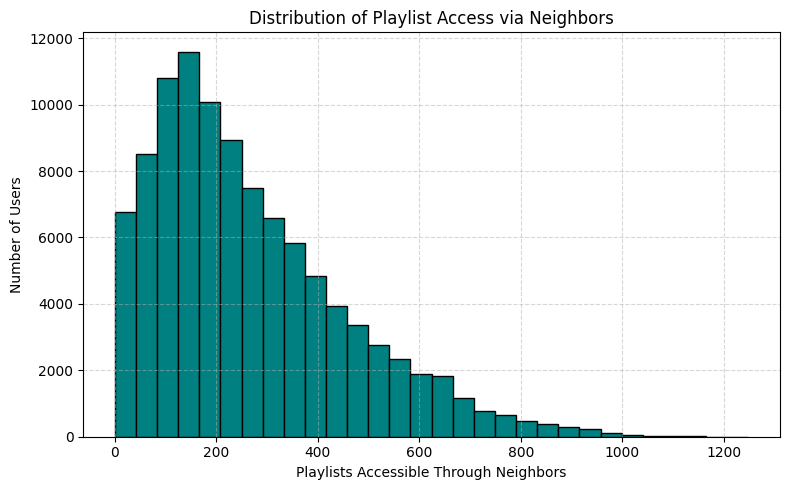

In [18]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# === Config ===
NEIGHBOR_FILE = "/content/drive/MyDrive/datasets/main_datasets/user_pairing_model/user_neighbors_downscaled_v2.pkl"
OWNED_PLAYLISTS_FILE = "/content/drive/MyDrive/datasets/playlist_ownership/user_owned_playlists.pkl"

# === Load Data ===
with open(NEIGHBOR_FILE, "rb") as f:
    user_neighbors = pickle.load(f)

with open(OWNED_PLAYLISTS_FILE, "rb") as f:
    user_owned_playlists = pickle.load(f)

# === Compute playlists accessible via neighbors ===
playlist_counts = []

for uid, neighbors in tqdm(user_neighbors.items(), desc="Computing playlist coverage"):
    playlists = set()
    for nbr in neighbors:
        playlists.update(user_owned_playlists.get(nbr, set()))
    playlist_counts.append(len(playlists))

# === Stats ===
print("\n📊 Playlists Accessible via Neighbors:")
print(f" - Users analyzed         : {len(playlist_counts):,}")
print(f" - Min playlists          : {min(playlist_counts)}")
print(f" - Max playlists          : {max(playlist_counts)}")
print(f" - Mean playlists         : {np.mean(playlist_counts):.2f}")
print(f" - Median playlists       : {np.median(playlist_counts)}")
print(f" - 25th percentile        : {np.percentile(playlist_counts, 25)}")
print(f" - 75th percentile        : {np.percentile(playlist_counts, 75)}")
print(f" - 99th percentile        : {np.percentile(playlist_counts, 99)}")

# === Plot histogram ===
plt.figure(figsize=(8, 5))
plt.hist(playlist_counts, bins=30, color="teal", edgecolor="black")
plt.title("Distribution of Playlist Access via Neighbors")
plt.xlabel("Playlists Accessible Through Neighbors")
plt.ylabel("Number of Users")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [2]:
import pickle
import numpy as np
from tqdm import tqdm

# === Config ===
NEIGHBOR_FILE = "/content/drive/MyDrive/datasets/main_datasets/user_pairing_model/user_neighbors_downscaled_v2.pkl"
OWNED_PLAYLISTS_FILE = "/content/drive/MyDrive/datasets/playlist_ownership/user_owned_playlists.pkl"

# === Load Data ===
with open(NEIGHBOR_FILE, "rb") as f:
    user_neighbors = pickle.load(f)

with open(OWNED_PLAYLISTS_FILE, "rb") as f:
    user_owned_playlists = pickle.load(f)

# === Count playlists for each user
playlist_counts = []

for uid, neighbors in tqdm(user_neighbors.items(), desc="Counting playlists per user"):
    playlists = set()
    for nbr in neighbors:
        playlists.update(user_owned_playlists.get(nbr, set()))
    playlist_counts.append(len(playlists))

playlist_counts = np.array(playlist_counts)
total_users = len(playlist_counts)

# === Threshold stats
thresholds = [1, 5, 10, 20, 30, 50]
print("📊 Users with fewer than X playlists:")
for t in thresholds:
    count = np.sum(playlist_counts < t)
    share = (count / total_users) * 100
    print(f" - < {t:>2} playlists: {count:>6,} users ({share:5.2f}%)")

print(f"\n✅ Total users analyzed: {total_users:,}")


Counting playlists per user: 100%|██████████| 101713/101713 [00:07<00:00, 13527.21it/s]

📊 Users with fewer than X playlists:
 - <  1 playlists:     82 users ( 0.08%)
 - <  5 playlists:    594 users ( 0.58%)
 - < 10 playlists:  1,315 users ( 1.29%)
 - < 20 playlists:  2,875 users ( 2.83%)
 - < 30 playlists:  4,755 users ( 4.67%)
 - < 50 playlists:  8,200 users ( 8.06%)

✅ Total users analyzed: 101,713


## Save precomputed user to neighbor's playlist pairing, setting a max of 75 playlists.

In [3]:
import os
import pickle
import random
from tqdm import tqdm

# === Configuration ===
NEIGHBOR_FILE = "/content/drive/MyDrive/datasets/main_datasets/user_pairing_model/user_neighbors_downscaled_v2.pkl"
OWNED_PLAYLISTS_FILE = "/content/drive/MyDrive/datasets/playlist_ownership/user_owned_playlists.pkl"
OUTPUT_PATH = "/content/drive/MyDrive/datasets/main_datasets/user_playlist_match/user_to_neighboursPlaylists.pkl"
MAX_PLAYLISTS = 75
SEED = 42
random.seed(SEED)

# === Load Data ===
with open(NEIGHBOR_FILE, "rb") as f:
    user_neighbors = pickle.load(f)

with open(OWNED_PLAYLISTS_FILE, "rb") as f:
    user_owned_playlists = pickle.load(f)

# === Build Mapping: user_id → list of playlist_ids
user_to_playlists = {}

for user_id, neighbors in tqdm(user_neighbors.items(), desc="Building mapping"):
    playlists = set()
    for nbr in neighbors:
        playlists.update(user_owned_playlists.get(nbr, set()))

    playlist_list = list(playlists)
    if len(playlist_list) > MAX_PLAYLISTS:
        playlist_list = random.sample(playlist_list, MAX_PLAYLISTS)
    user_to_playlists[user_id] = playlist_list

# === Save for Inference ===
os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)
with open(OUTPUT_PATH, "wb") as f:
    pickle.dump(user_to_playlists, f)

print(f"✅ Saved user-to-playlist mapping with {len(user_to_playlists)} users → {OUTPUT_PATH}")


Building mapping: 100%|██████████| 101713/101713 [00:10<00:00, 9772.74it/s]


✅ Saved user-to-playlist mapping with 101713 users → /content/drive/MyDrive/datasets/main_datasets/user_playlist_match/user_to_neighboursPlaylists.pkl


In [5]:
import os
import pickle

# === Configuration ===
INPUT_PATH = "/content/drive/MyDrive/datasets/main_datasets/user_playlist_match/user_to_neighboursPlaylists.pkl"
OUTPUT_CLEAN_PATH = "/content/drive/MyDrive/datasets/main_datasets/user_playlist_match/user_to_neighboursPlaylists_clean.pkl"
REMOVED_USERS_PATH = "/content/drive/MyDrive/datasets/main_datasets/user_playlist_match/removed_users_5playlistsRequirement.pkl"
MIN_PLAYLISTS = 5

# === Load original user→playlist mapping
with open(INPUT_PATH, "rb") as f:
    user_to_playlists = pickle.load(f)

# === Filter users
user_to_playlists_clean = {}
removed_users = set()

for user_id, playlist_ids in user_to_playlists.items():
    if len(playlist_ids) >= MIN_PLAYLISTS:
        user_to_playlists_clean[user_id] = playlist_ids
    else:
        removed_users.add(user_id)

# === Save outputs
with open(OUTPUT_CLEAN_PATH, "wb") as f:
    pickle.dump(user_to_playlists_clean, f)

with open(REMOVED_USERS_PATH, "wb") as f:
    pickle.dump(removed_users, f)

print(f"✅ Cleaned mapping saved: {len(user_to_playlists_clean)} users kept.")
print(f"🗑️ Removed {len(removed_users)} users with < {MIN_PLAYLISTS} playlists.")


✅ Cleaned mapping saved: 101119 users kept.
🗑️ Removed 594 users with < 5 playlists.
